In [124]:
import pandas as pd
import numpy as np
import os, sys, time, joblib, json
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append("src/")
from constants import *
sys.path.append("src/NN_models/")
from network import *

### Load the trained model object

In [3]:
def choose_embedding_size(cat_cols, cat_num_values, min_emb_dim=100):
    """
    cat_cols: list of categorical columns
    cat_num_values: list of number of unique values for each
    categorical column
    """
    embedded_cols = dict(zip(cat_cols, cat_num_values))
    embedding_sizes = [
        (n_categories, min(min_emb_dim, (n_categories+1)//2))
         for _, n_categories in embedded_cols.items()]
    return embedding_sizes

In [10]:
# GLOBALS
FILE_NUM = 1
BATCH_SIZE = 50 
TEST_SIZE = 240538
CAT_COLS = ['User', 'Movie']
N_USERS = 480189
N_ITEMS = 17770
N_CONT = 768+15
MIN_EMB_DIM = 100

In [5]:
embedding_sizes = choose_embedding_size(
    CAT_COLS, [N_USERS, N_ITEMS], MIN_EMB_DIM)
embedding_sizes

[(480189, 100), (17770, 100)]

In [6]:
import torch


model_fn = os.path.join(MODEL_DIR,
                        'NN_DenseFFNN_FBaselineAndTitleEmbBert_E2.pt')

model = DenseFFNN(embedding_sizes, N_CONT)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.load_state_dict(torch.load(model_fn, map_location=device))

cpu


<All keys matched successfully>

### Choose examples from the test set for visualization

In [11]:
from tqdm import tqdm
import torch.nn as nn
from torch import tensor
from custom_data_loader import InteractionsStream

In [12]:
def construct_tensor_test(a):
    out = []
    for i in a:
        out.append(i.tolist())
        out1 = []
        for item in zip(*out):
            out1.append(list(item))
    return tensor(out1)


def predict(model, valid_dl, test_size, batch_size, device,
            loss_fn=nn.MSELoss(reduction='sum')):
        model.eval()
        total = 0
        sum_loss = 0
        preds = []
        actuals = []
        cat_feats = []
        num_feats = []
        with tqdm(total=test_size // (batch_size)) as pbar:
            for x1, x2, y in valid_dl:
                x1, x2 = (construct_tensor_test(x1),
                          construct_tensor_test(x2))
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                current_batch_size = y.size()[0]
                y = y.reshape((y.size()[0], 1))
                y = y.float()
                out = model(x1, x2)
                loss = loss_fn(out, y)
                sum_loss += loss.item()
                total += current_batch_size
                cat_feats.append(x1.detach().numpy())
                num_feats.append(x2.detach().numpy())
                actuals.append(y.detach().numpy().tolist())
                preds.append(out.detach().numpy().tolist())
                pbar.update(1)

        return sum_loss/total, actuals, preds, cat_feats, num_feats

In [13]:
# read
out_fn = os.path.join(
    VISUALIZATION_DIR,
    'test_data_for_visualization_{}.h5'.format(FILE_NUM))
pred_df = pd.read_hdf(out_fn, key='stage')

In [14]:
pred_df.head()

,actual,pred,cat_feats,num_feats,MSE
0,[4.0],[4.0],"[141335, 2742]","[912.0, 30.199337, 1724.0, 246.28572, 57.46666...",0.000000e+00
1,[3.0],[3.0000030994415283],"[222657, 2199]","[6.0, 2.4494898, 197.0, 28.142857, 6.5666666, ...",9.606538e-12
2,[3.0],[2.9999961853027344],"[310545, 2199]","[0.0, 0.0, 211.0, 30.142857, 7.0333333, 3.7031...",1.455192e-11
3,[3.0],[2.999993085861206],"[171594, 3341]","[1245.0, 35.284557, 1753.0, 250.42857, 58.4333...",4.780532e-11
4,[2.0],[2.0000083446502686],"[243525, 107]","[25.0, 5.0, 334.0, 47.714287, 11.133333, 1.484...",6.963319e-11


In [134]:
# positive, negative and baseline examples
mean_mse = pred_df['MSE'].mean()
pos_examples = pred_df.head(30)
neg_examples = pred_df.tail(30)
neg_examples.reset_index(drop=True, inplace=True)
mask = (pred_df['MSE'] >= mean_mse - 1e-5) & (pred_df['MSE'] <= mean_mse + 1e-5)
baseline_example = pred_df.loc[mask, :]
baseline_example.reset_index(drop=True, inplace=True)
baseline_example = baseline_example.loc[0, :]

#print(pos_examples)
#print(neg_examples)
#print(baseline_example)

In [101]:
x1_pos, x2_pos = (tensor(pos_examples['cat_feats']),
                  tensor(pos_examples['num_feats']))
#x1_pos = x1_pos.reshape(1, x1_pos.size()[0])
#x2_pos = x2_pos.reshape(1, x2_pos.size()[0])
x1_neg, x2_neg = (tensor(neg_examples['cat_feats']),
                  tensor(neg_examples['num_feats']))
#x1_neg = x1_neg.reshape(1, x1_neg.size()[0])
#x2_neg = x2_neg.reshape(1, x2_neg.size()[0])
x1_base, x2_base = (tensor(baseline_example['cat_feats']),
                    tensor(baseline_example['num_feats']))
x1_base = x1_base.reshape(1, x1_base.size()[0])
x2_base = x2_base.reshape(1, x2_base.size()[0])

#print(x1_pos, x2_pos)

### Interpretation

In [95]:
from captum.attr import (
    LayerIntegratedGradients,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    visualization
)

In [96]:
model.eval()

DenseFFNN(
  (embeddings): ModuleList(
    (0): Embedding(480189, 100)
    (1): Embedding(17770, 100)
  )
  (lin1): Linear(in_features=983, out_features=300, bias=True)
  (lin2): Linear(in_features=300, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=1, bias=True)
  (bn1): BatchNorm1d(783, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

### Layerwise Attribution using Integrated Gradients Approach
1. Contribution of each neuron in a layer w.r.t output

#### User Embeddings

In [105]:
lig = LayerIntegratedGradients(model, model.embeddings[0])
pos_attributions, delta = lig.attribute(
    (x1_pos, x2_pos), (x1_base, x2_base), n_steps=500,
    return_convergence_delta=True)
print('pos delta: ', delta)

neg_attributions, delta = lig.attribute(
    (x1_neg, x2_neg), (x1_base, x2_base), n_steps=500,
    return_convergence_delta=True)
print('neg delta: ', delta)

pos delta:  tensor([-0.2868,  1.4086,  0.9618,  0.6760,  2.0351, -0.1313, -0.4284,  0.1238,
         1.0727,  0.1415, -0.2090,  1.1347,  0.0887,  0.9553,  0.0304,  1.3921,
         0.0139,  1.0250,  0.4317,  0.2323, -0.1530, -0.1754,  0.4804,  0.8227,
         0.8521, -0.0614, -0.0871,  0.2094,  0.1553, -1.0270])
neg delta:  tensor([ 2.5489, -0.7350, -0.8252, -0.7924, -0.9062, -0.8820, -0.4742, -0.5089,
        -0.8476, -0.8199, -0.6804, -0.8234, -0.8854, -0.8034, -0.8709, -0.6696,
        -0.8455, -0.8512, -0.8996, -0.8771, -0.9759, -0.9784, -1.1023, -1.0245,
        -0.9801, -1.0255, -0.9204, -0.9500, -0.9872, -1.1107])


In [110]:
pos_attributions.shape, neg_attributions.shape

(torch.Size([30, 100]), torch.Size([30, 100]))

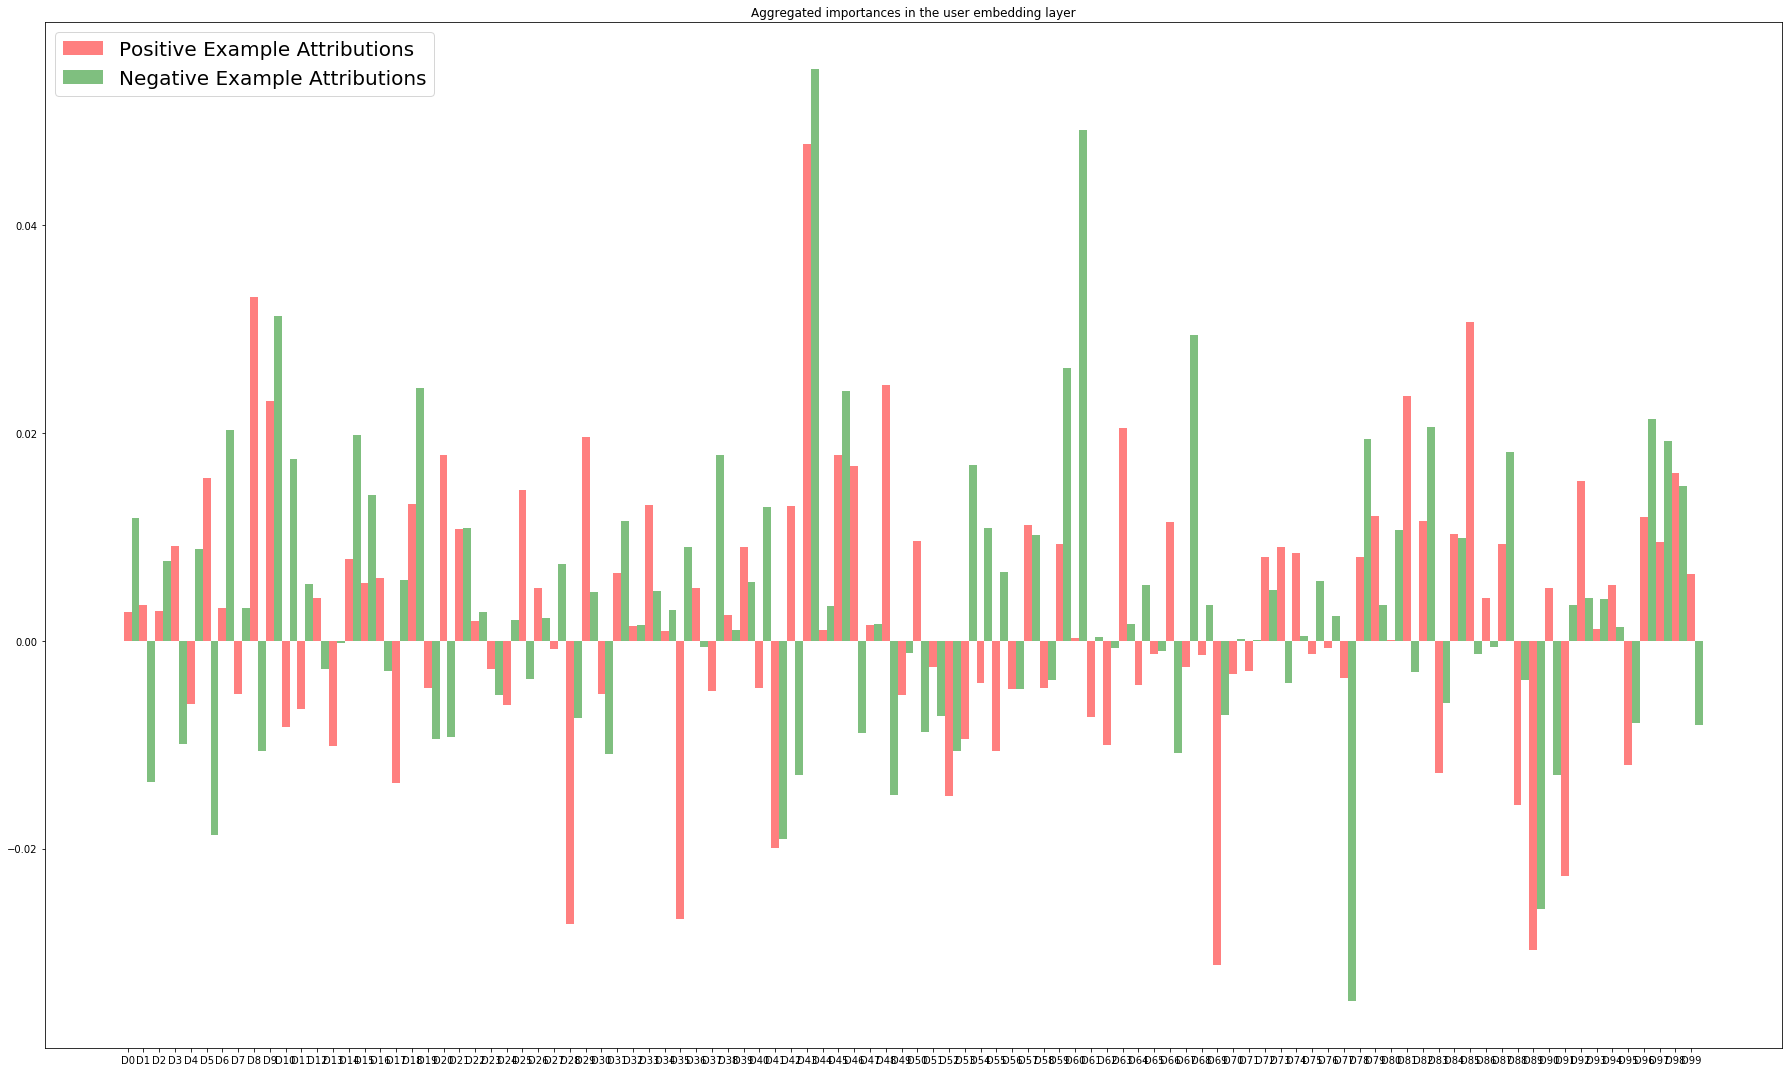

In [130]:
plt.figure(figsize=(25, 15))

x_axis_data = np.arange(pos_attributions.shape[1])
lig_attr_pos = pos_attributions.mean(0).detach().numpy()
lig_attr_pos = lig_attr_pos/np.linalg.norm(lig_attr_pos, ord=1)
lig_attr_neg = neg_attributions.mean(0).detach().numpy()
lig_attr_neg = lig_attr_neg/np.linalg.norm(lig_attr_neg, ord=1)

width = 0.5
legends = ['Positive Example Attributions','Negative Example Attributions']
x_axis_labels = ['D{}'.format(i) for i in range(len(x_axis_data))]

ax = plt.subplot()
ax.set_title('Aggregated importances in the user embedding layer')

ax.bar(x_axis_data + width, lig_attr_pos, width, align='center',
       alpha=0.5, color='red')
ax.bar(x_axis_data + 2 * width, lig_attr_neg, width, align='center',
       alpha=0.5, color='green')
plt.legend(legends, loc=2, prop={'size': 20})
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_labels)

plt.show()

#### Observations
1. The attribution of user embeddings for the positive examples is in most cases a mirror reflection of those for the negative examples

#### Possible Reasons
1. Low number of ratings - sparsity
2. What kind of movies are rated by these users
3. What kind of ratings are given by these users

In [131]:
# read train data
%time df_train = pd.read_hdf(TRAIN_FN.format(1))

CPU times: user 6.73 s, sys: 4.05 s, total: 10.8 s
Wall time: 13.6 s


In [138]:
# read user2idx
%time user2idx = json.load(open(USER2IDX_FN))
df_train['mapped_user'] = df_train['User'].apply(
    lambda x: user2idx[str(x)])
del user2idx

CPU times: user 328 ms, sys: 226 ms, total: 554 ms
Wall time: 740 ms


In [162]:
# read item2idx
%time item2idx = json.load(open(ITEM2IDX_FN))
df_train['mapped_item'] = df_train['Movie'].apply(
    lambda x: item2idx[str(x)])
del item2idx

CPU times: user 6.58 ms, sys: 3.41 ms, total: 10 ms
Wall time: 9.07 ms


In [163]:
df_train.head()

,User,Rating,Date,Movie,num_rating_user,num_rating_user_bins,num_rating_movie,num_rating_movie_bins,mapped_user,mapped_item
0,2291417,4.0,2004-07-17,2139,47,10,22332,9,161459,2138
1,2258090,2.0,2004-03-14,3254,215,14,62628,9,87375,3253
2,371378,2.0,2005-12-23,1155,135,13,1788,6,191296,1154
3,1483177,5.0,2004-09-26,1202,158,13,78878,9,27266,1201
4,1916501,3.0,2004-08-03,4378,72,11,711,5,175666,4377


In [172]:
pos_examples['user'] = pos_examples['cat_feats'].apply(lambda x: x[0])
pos_examples['rating'] = pos_examples['actual'].apply(lambda x: x[0])
pos_examples['movie'] = pos_examples['cat_feats'].apply(lambda x: x[1])
neg_examples['user'] = neg_examples['cat_feats'].apply(lambda x: x[0])
neg_examples['rating'] = neg_examples['actual'].apply(lambda x: x[0])
neg_examples['movie'] = neg_examples['cat_feats'].apply(lambda x: x[1])

pos_users = pos_examples['user'].unique().tolist()
neg_users = neg_examples['user'].unique().tolist()

print(len(pos_users), '\t', len(neg_users))

30 	 30


/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [146]:
# number of ratings
def get_num_user_ratings(user_lst):
    mask = df_train['mapped_user'].isin(user_lst)
    tmp = df_train.loc[mask, :]
    tmp.reset_index(drop=True, inplace=True)
    table = tmp.groupby('mapped_user')['Rating'].count().rename(
        'num_ratings').reset_index()
    return table

In [151]:
num_pos_user_ratings = get_num_user_ratings(pos_users)
num_neg_user_ratings = get_num_user_ratings(neg_users)
print('pos', '\t', num_pos_user_ratings['num_ratings'].describe())
print('neg', '\t', num_neg_user_ratings['num_ratings'].describe())

pos 	 count     30.000000
mean     144.866667
std      144.456110
min        9.000000
25%       34.000000
50%       92.500000
75%      204.250000
max      547.000000
Name: num_ratings, dtype: float64
neg 	 count     30.000000
mean      60.833333
std      100.851575
min        1.000000
25%        9.250000
50%       24.000000
75%       63.000000
max      515.000000
Name: num_ratings, dtype: float64


#### The number of ratings for negative users is significantly lower than that of the positive users

In [152]:
# mean ratings
def get_mean_user_ratings(user_lst):
    mask = df_train['mapped_user'].isin(user_lst)
    tmp = df_train.loc[mask, :]
    tmp.reset_index(drop=True, inplace=True)
    table = tmp.groupby('mapped_user')['Rating'].mean().rename(
        'mean_ratings').reset_index()
    return table

In [161]:
mean_pos_user_ratings = get_mean_user_ratings(pos_users)
mean_neg_user_ratings = get_mean_user_ratings(neg_users)
print('pos', '\t', 'train: ',
      mean_pos_user_ratings['mean_ratings'].mean(), '\t', 'test: ',
      pos_examples['rating'].mean())
print('neg', '\t', 'train: ',
      mean_neg_user_ratings['mean_ratings'].mean(), '\t', 'test: ',
      neg_examples['rating'].mean())

pos 	 train:  3.620591063332109 	 test:  3.533333333333333
neg 	 train:  4.376072871063167 	 test:  1.1333333333333333


#### The mean ratings of train and test samples are not very different in the case of positive examples whereas the difference looks significant in the case of negative examples  

In [168]:
def desc_movie_ratings(movie_lst):
    mask = df_train['mapped_item'].isin(movie_lst)
    tmp = df_train.loc[mask, :]
    tmp.reset_index(drop=True, inplace=True)
    count_df = tmp.groupby('mapped_item')['Rating'].count().rename(
        'num_ratings').reset_index()
    mean_df = tmp.groupby('mapped_item')['Rating'].mean().rename(
        'mean_ratings').reset_index()
    table = pd.merge(count_df, mean_df, on=['mapped_item'])
    return table

In [174]:
mask = df_train['mapped_user'].isin(pos_users)
pos_movies = df_train.loc[mask, 'mapped_item'].unique().tolist()
test_pos_movies = pos_examples['movie'].unique().tolist()

mask = df_train['mapped_user'].isin(neg_users)
neg_movies = df_train.loc[mask, 'mapped_item'].unique().tolist()
test_neg_movies = neg_examples['movie'].unique().tolist()

print('# train pos movies: ', len(pos_movies), '\t',
      '# test pos movies: ', len(test_pos_movies))
print('# train neg movies: ', len(neg_movies), '\t',
      '# test neg movies: ', len(test_neg_movies))

# train pos movies:  1570 	 # test pos movies:  29
# train neg movies:  846 	 # test neg movies:  27


In [176]:
pos_movies_desc = desc_movie_ratings(pos_movies)
neg_movies_desc = desc_movie_ratings(neg_movies)

print('pos')
print('train # ratings: ', pos_movies_desc['num_ratings'].mean())
print('train mean ratings: ', pos_movies_desc['mean_ratings'].mean())
print('test mean ratings: ', pos_examples['rating'].mean())

print('\n')

print('neg')
print('train # ratings: ', neg_movies_desc['num_ratings'].mean())
print('train mean ratings: ', neg_movies_desc['mean_ratings'].mean())
print('test mean ratings: ', neg_examples['rating'].mean())

pos
train # ratings:  13295.8
train mean ratings:  3.3954825295304265
test mean ratings:  3.533333333333333


neg
train # ratings:  21984.741134751774
train mean ratings:  3.4751366135225195
test mean ratings:  1.1333333333333333


#### There is a significant difference in the mean ratings of movies watched by negative users between train and test samples

#### Movie Embeddings

In [178]:
model

DenseFFNN(
  (embeddings): ModuleList(
    (0): Embedding(480189, 100)
    (1): Embedding(17770, 100)
  )
  (lin1): Linear(in_features=983, out_features=300, bias=True)
  (lin2): Linear(in_features=300, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=1, bias=True)
  (bn1): BatchNorm1d(783, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

In [179]:
lig = LayerIntegratedGradients(model, model.embeddings[1])
pos_attributions, delta = lig.attribute(
    (x1_pos, x2_pos), (x1_base, x2_base), n_steps=500,
    return_convergence_delta=True)
print('pos delta: ', delta)

neg_attributions, delta = lig.attribute(
    (x1_neg, x2_neg), (x1_base, x2_base), n_steps=500,
    return_convergence_delta=True)
print('neg delta: ', delta)

pos delta:  tensor([-0.1138,  0.8536,  0.9021,  0.9862,  2.2688,  0.1823, -0.2179, -0.0657,
         0.9418, -0.0084, -0.1265,  0.7692, -0.0046,  0.5982,  0.2690,  0.6754,
         0.8513,  0.8221,  0.6990,  0.0929,  0.1540, -0.3373,  0.1546,  1.0324,
         1.0797,  0.0338,  0.2448,  0.0939,  0.2269, -1.0539])
neg delta:  tensor([ 2.4881, -0.7881, -0.7813, -0.8088, -0.8386, -0.8394, -0.6005, -0.7341,
        -0.9292, -0.8501, -0.8277, -0.7332, -0.8523, -0.8309, -0.9426, -0.7746,
        -0.9000, -0.8208, -0.8732, -0.8771, -0.8300, -0.9236, -0.9963, -1.0175,
        -0.9953, -1.0225, -0.9592, -1.0531, -0.9382, -1.1461])
